# Analysis

This analysis is done on AOSP to evaluate three different hypothetical ways to elide tag checks:

1. A system where there is an **instruction to explicitely check** a pointer for validity,
1. A system where there is a prefix **instruction to elide** the tag check on the immediately following instruction
1. A system where there is **both** of the above.

All of the systems have a way to mark a whole codepage as being either default checked or unchecked.

The data is obtained by buliding with HWASan, and using optimization remarks to determine whether accesses
can be proven safe or not by stack safety analysis. In total, stack safety can prove 5580103 accesses, and
cannot prove 16335447 of them.

# Results

For the system with an **instruction to explicitely check** we would need to emit 7727452 of those.
This is the number of accesses that can not be proven safe in functions that have some accesses that can be. These
functions would be placed on a default-unchecked page, with explicit checks for the accesses we cannot prove.

For the system with an **instruction to elide** we would need to emit 5472311 of those.
This is the number of accesses that can be proven safe in functions that have some accesses that cannot be. These
functions would be placed on a default-checked page, with elide instructions for the accesses we can prove.

For the system with an **both**, we would need to emit 3967045 instructions (check and elide combined).
For each function, this is the minimum number of the two above, because now the code generation has the flexibility
to choose whichever is optimal on a per-function basis.

Note: the results for **instruction to explicitely check** can be optimized further by recognizing the fact that
if there are multiple accesses to the same pointer, we do not need multiple checks in all cases. Also, further
improvements in the compiler could lead to more accesses being proven safe. We currently make no attempt to prove
heap accesses safe.

# Metholodogy

Applied this patch to AOSP: https://r.android.com/3693469

```
$ export FORCE_AUDIO_SILENT=true
$ export OUT_DIR=a64h_out
$ export SANITIZE_TARGET=hwaddress
$ source build/envsetup.sh
$ lunch aosp_arm64-aosp_current-userdebug
$ m
````

```
$ cd a64h_out
$ for f in $(find -name '*.yaml'); do mkdir -p ~/yamls/$(dirname $f); cp $f ~/yamls/$(dirname $f); done
```

```python
import sys
import os
import ruamel.yaml
import json
from collections import defaultdict

data = defaultdict(lambda: [0, 0])
fileset = set()

def handle_file(fn):
    if fn in fileset:
        return
    fileset.add(fn)
    yaml = ruamel.yaml.YAML()
    with open(fn, 'r') as fd:
        for x in yaml.load_all(fd):
            if x.get('Pass', None) != 'hwasan' or x.get('Name', None) != 'ignoreAccess':
                continue
            data[fn + ':' + x['Function']][x.tag == '!Passed'] += 1

if __name__ == '__main__':
    for root, dirs, files in os.walk(sys.argv[1]):
        for filename in files:
            if not filename.endswith('yaml'):
                continue
            handle_file(os.path.join(root, filename))
            print('.', end='')
            sys.stdout.flush()
    with open('result.json', 'w') as fd:
        json.dump(data, fd)

```

In [25]:
import json
import numpy as np
import matplotlib.pyplot as plt

In [26]:
with open('result.json') as f:
    data = json.load(f)

(array([1.46000e+03, 6.40000e+01, 2.60000e+01, 2.20000e+01, 3.30000e+01,
        3.10000e+01, 1.70000e+01, 3.70000e+01, 3.40000e+01, 1.10000e+01,
        3.00000e+01, 2.20000e+01, 3.90000e+01, 2.20000e+01, 2.50000e+01,
        3.20000e+01, 1.70000e+01, 3.60000e+01, 4.10000e+01, 2.30000e+01,
        3.30000e+01, 3.80000e+01, 3.50000e+01, 2.40000e+01, 4.50000e+01,
        3.70000e+01, 3.90000e+01, 3.30000e+01, 4.70000e+01, 5.60000e+01,
        5.70000e+01, 4.20000e+01, 6.50000e+01, 4.70000e+01, 8.60000e+01,
        5.70000e+01, 5.00000e+01, 6.00000e+01, 6.70000e+01, 7.40000e+01,
        8.00000e+01, 9.20000e+01, 6.20000e+01, 6.50000e+01, 7.20000e+01,
        1.18000e+02, 8.00000e+01, 9.10000e+01, 7.40000e+01, 9.40000e+01,
        1.33000e+02, 4.07000e+02, 1.16000e+02, 1.21000e+02, 1.23800e+03,
        1.60000e+02, 1.03000e+02, 1.44000e+02, 2.32000e+02, 1.69000e+02,
        1.62000e+02, 2.74000e+02, 2.24000e+02, 1.61000e+02, 4.05000e+02,
        1.70000e+02, 1.52000e+02, 1.55000e+02, 2.43

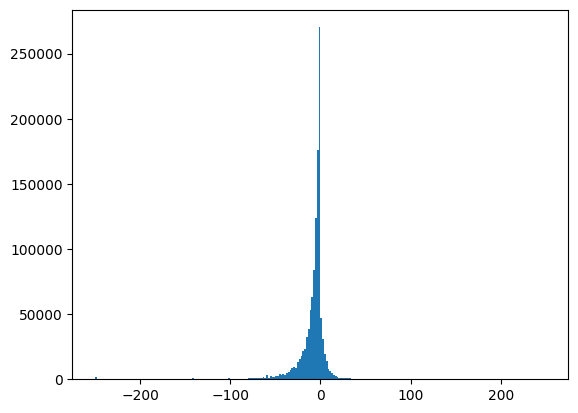

In [27]:
plt.hist(
    np.clip([v[1] - v[0] for _, v in data.items()], -250, 250),
    bins=250
)

In [ ]:
# We only need to emit checks if there are SOME unchecked in the function,
# otherwise just place on a checked page.
checked = sum([v[0] for _, v in data.items() if v[1]])
# We only need to elide if there are SOME we want to check, otherwise just
# place on a non-checked page.
elided = sum([v[1] for _, v in data.items() if v[0]])

In [ ]:
print("Check instructions ", checked)

Check instructions  7727452


In [ ]:
print("Elide instructions ", elided)

Elide instructions  5472311


In [ ]:
print("Optimal            ", sum([min(v) for _, v in data.items()]))

Optimal             3967045


In [ ]:
checked / elided

1.4121002991240812

In [ ]:
((checked - elided) * 4) / 1024**2

8.602680206298828

In [ ]:
total_checked = sum(v[0] for _, v in data.items())
total_elided = sum(v[1] for _, v in data.items())

In [ ]:
print("Total checked ", total_checked)

Total checked  16335447


In [ ]:
print("Total elided ", total_elided)

Total elided  5580103
